In [1]:
# import packages for analysis and modeling
import pandas as pd  # data frame operations
#from pandas.tools.plotting import scatter_matrix  # scatter plot matrix
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification
import numpy as np  # arrays and math functions
import matplotlib.pyplot as plt  # 2D plotting
#import zipcodes
#import pyzipcode

from pandas import Series
from scipy.stats import uniform  # for training-and-test split
from scipy.stats import boxcox
from sklearn.tree import DecisionTreeRegressor  # machine learning tree
from sklearn.ensemble import RandomForestRegressor # ensemble method
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from pprint import pprint
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from math import sqrt


# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff



# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [2]:
house = pd.read_csv('clean_house_data.csv', encoding = "ISO-8859-1")
house.head()

,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,...,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06
0,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,1,337200.0,338200.0,339000.0,339700.0,...,1047600,1049400,1048800,1049900,1054300,1059400,1067800,1080400,1082300,1072200
1,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,2,210400.0,212200.0,212200.0,210700.0,...,338100,336700,336100,336200,335500,334200,333500,333500,333400,332300
2,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,3,502900.0,504900.0,506300.0,507200.0,...,1319100,1317900,1319800,1324200,1330000,1336400,1342000,1347400,1345200,1334500
3,77449,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4,95400.0,95600.0,95800.0,96100.0,...,178500,179400,180300,181100,182100,183300,183000,181800,181800,182800
4,79936,El Paso,TX,El Paso,El Paso County,5,77300.0,77300.0,77300.0,77300.0,...,125700,126400,126900,127600,128200,128600,128900,128700,128500,128800


In [3]:
# going to do for 1 first
# AR 97 - 2017
ar = house.loc[house.State == 'AR']
ar = ar.drop(ar.loc[:,ar.columns[6:15]], axis=1)
ar = ar.drop(ar.loc[:,ar.columns[258:]], axis=1)
ar.head()

,RegionName,City,State,Metro,CountyName,SizeRank,1997-01,1997-02,1997-03,1997-04,...,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
245,72401,Jonesboro,AR,Jonesboro,Craighead County,254,53000.0,53100.0,53200.0,53400.0,...,109200,109500,109300,108900,108500,108500,108800,109200,109400,109600
283,71913,Hot Springs,AR,Hot Springs,Garland County,294,79300.0,79100.0,78900.0,78900.0,...,143900,143700,144300,145400,145700,145700,146500,147400,147800,146700
588,72034,Conway,AR,Little Rock-North Little Rock-Conway,Faulkner County,608,82400.0,83400.0,84400.0,85300.0,...,170300,171300,172100,173100,173300,172700,171600,170500,169500,169000
770,72701,Fayetteville,AR,Fayetteville-Springdale-Rogers,Washington County,796,83800.0,84400.0,85000.0,85500.0,...,190600,192000,192700,193100,194300,195400,196400,198100,200400,202500
1438,72076,Jacksonville,AR,Little Rock-North Little Rock-Conway,Pulaski County,1483,60400.0,60900.0,61400.0,61800.0,...,96600,97400,97600,98400,99700,100100,99700,99400,97700,94400


In [4]:
#AR 2018 - pres
ar_validate = house.loc[house.State == 'AR']
ar_validate = ar_validate.drop(ar_validate.loc[:,ar_validate.columns[6:267]], axis=1)
ar_validate.head()

,RegionName,City,State,Metro,CountyName,SizeRank,2018-01,2018-02,2018-03,2018-04,...,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06
245,72401,Jonesboro,AR,Jonesboro,Craighead County,254,109800,110200,110900,111000,...,109600,110800,113800,116500,117500,117900,117800,117800,118900,120100
283,71913,Hot Springs,AR,Hot Springs,Garland County,294,145300,144900,145100,144700,...,146800,146900,147700,149000,150500,151300,151700,152000,151500,150300
588,72034,Conway,AR,Little Rock-North Little Rock-Conway,Faulkner County,608,169000,169200,169400,169700,...,172300,173400,174000,174300,174900,175700,175800,175000,174700,175000
770,72701,Fayetteville,AR,Fayetteville-Springdale-Rogers,Washington County,796,205300,209200,212600,214300,...,220700,223100,225200,227300,228800,229600,229700,229900,231800,234200
1438,72076,Jacksonville,AR,Little Rock-North Little Rock-Conway,Pulaski County,1483,92300,92500,93500,94700,...,100000,100400,101000,102000,103100,103200,103100,103000,103200,103500


In [5]:
#print(ar.columns[6:])
test = pd.melt(ar, id_vars=['RegionName'], value_vars=ar.columns[6:])

In [6]:
t = test.loc[test.RegionName == 72401]
print(test.shape)
print(t.shape)
print(len(test.RegionName.unique()))

(23436, 3)
(252, 3)
93


In [7]:
t2 = t.drop(t.loc[:,['RegionName']], axis=1)

In [8]:
#t2.variable = pd.to_datetime(t2.variable)
#t2.to_csv('test_time.csv', index=False)
#t_series = Series.from_csv('test_time.csv')
#t_series.values[1:]

In [9]:
# prepare data
X = t2.value
X = X.astype('float32')
X = X.values

#t_series
#X = t_series.values[1:]
#X = X.astype('float32')

train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()

#'''
for i in range(len(test)):
    # difference data
    months = 12
    diff = difference(history, months)
    # predict
    model = ARIMA(diff, order=(2,1,0))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    #print(yhat)
    yhat = inverse_difference(history, yhat, months)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
#'''

>Predicted=91678.102, Expected=91500
>Predicted=91436.280, Expected=91300
>Predicted=91089.811, Expected=91100
>Predicted=90773.118, Expected=90800
>Predicted=90507.128, Expected=90700
>Predicted=90570.478, Expected=90700
>Predicted=90948.183, Expected=90800
>Predicted=90817.552, Expected=90800
>Predicted=90817.525, Expected=90800
>Predicted=90817.499, Expected=90700
>Predicted=90583.767, Expected=90600
>Predicted=90426.066, Expected=90600
>Predicted=90593.495, Expected=90600
>Predicted=90442.365, Expected=90500
>Predicted=90433.663, Expected=90400
>Predicted=90191.152, Expected=90400
>Predicted=90658.435, Expected=90400
>Predicted=90408.503, Expected=90400
>Predicted=90458.674, Expected=90400
>Predicted=90267.476, Expected=90500
>Predicted=90672.924, Expected=90500
>Predicted=90359.831, Expected=90400
>Predicted=90300.000, Expected=90300
>Predicted=90300.000, Expected=90400
>Predicted=90531.122, Expected=90600
>Predicted=90722.335, Expected=90900
>Predicted=91245.681, Expected=91200
>

In [10]:
# going to do for 1 first
# AR 97 - 2017
ar = house.loc[house.State == 'AR']
ar = ar.drop(ar.loc[:,ar.columns[6:15]], axis=1)
ar = ar.drop(ar.loc[:,ar.columns[258:]], axis=1)

ar_validate = house.loc[house.State == 'AR']
ar_validate = ar_validate.drop(ar_validate.loc[:,ar_validate.columns[6:267]], axis=1)


In [57]:
zips = ar.RegionName.unique()

train = pd.melt(ar, id_vars=['RegionName'], value_vars=ar.columns[6:])
train_region = train.loc[train.RegionName == 72204]
train_region.head()

test = pd.melt(ar_validate, id_vars=['RegionName'], value_vars=ar_validate.columns[6:])
test_region = test.loc[test.RegionName == 72204]
test_region.head()

X = train_region.value.astype('float32').values
Y = test_region.value.astype('float32').values
D = test_region.variable.values

In [58]:
train, test, date = X, Y, D
# walk-forward validation
history = [x for x in train]
predictions = list()
df = pd.DataFrame(columns=['State', 'Zip', 'Date', 'Prediction'])
#'''
for i in range(len(test)):
    # difference data
    months = 12
    diff = difference(history, months)
    # predict
    model = ARIMA(diff, order=(2,1,0))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    #print(yhat)
    yhat = inverse_difference(history, yhat, months)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    #print('Prediction for {} : ${}'.format(date[i], round(float(yhat),2)))
    #print('>Predicted=%.3f, Expected=%3.f' % (yhat, date[i]))
    
    df = df.append({'State': 'AR',
                   'Zip': 72204,
                   'Date':date[i],
                   'Prediction':round(float(yhat),2)}, ignore_index=True)
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
#'''

RMSE: 693.742


In [59]:
df

,State,Zip,Date,Prediction
0,AR,72204,2018-01,67514.75
1,AR,72204,2018-02,67361.46
2,AR,72204,2018-03,67965.73
3,AR,72204,2018-04,66454.01
4,AR,72204,2018-05,66426.72
5,AR,72204,2018-06,67473.30
6,AR,72204,2018-07,68435.27
7,AR,72204,2018-08,68572.22
8,AR,72204,2018-09,70318.32
9,AR,72204,2018-10,70180.03


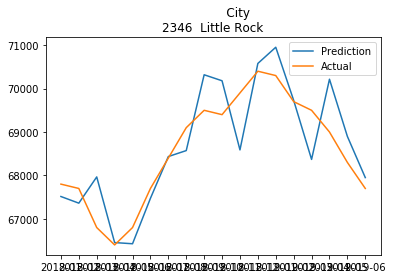

<Figure size 14400x7200 with 0 Axes>

In [60]:
'''
plt.plot(x, np.sin(x))
plt.title("A Sine Curve")
plt.xlabel("x")
plt.ylabel("sin(x)")


plt.plot(x, np.sin(x), '-g', label='sin(x)')
plt.plot(x, np.cos(x), ':b', label='cos(x)')
plt.axis('equal')

plt.legend();

'''

plt.plot(df.Date, df.Prediction, label = 'Prediction')
plt.plot(df.Date, test, label = 'Actual')
plt.title(str(ar_validate.loc[ar_validate.RegionName == df.iloc[0,1], ['City']]))
plt.legend()
plt.figure(figsize=(200,100))
#plt.savefig('htSprng.png')
plt.show()

In [15]:
test

array([109800., 110200., 110900., 111000., 110500., 109500., 109300.,
       109400., 109600., 110800., 113800., 116500., 117500., 117900.,
       117800., 117800., 118900., 120100.], dtype=float32)

In [25]:
ar_validate.loc[ar_validate.RegionName == 72401, ['City']]

,City
245,Jonesboro


In [29]:
df.iloc[0,1]

72401